# Load packages and data

In [4]:
!pip install catboost


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix, accuracy_score, mean_squared_error, f1_score


import warnings
warnings.simplefilter("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/Colab Notebooks/Data/credit_risk_dataset_new.csv'
df = pd.read_csv(path)

# A first glance at the data


In [9]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32409 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32409 non-null  int64  
 1   person_income               32409 non-null  int64  
 2   person_home_ownership       32409 non-null  object 
 3   person_emp_length           32409 non-null  int64  
 4   loan_intent                 32409 non-null  object 
 5   loan_grade                  32409 non-null  object 
 6   loan_amnt                   32409 non-null  int64  
 7   loan_int_rate               32409 non-null  float64
 8   loan_status                 32409 non-null  int64  
 9   loan_percent_income         32409 non-null  float64
 10  cb_person_default_on_file   32409 non-null  object 
 11  cb_person_cred_hist_length  32409 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.2+ MB


In [45]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32409.000000,3.240900e+04,32409.000000,32409.000000,32409.000000,32409.000000,32409.000000,32409.000000
mean,27.730754,6.589428e+04,4.825357,9592.486655,10.682286,0.218705,0.170248,5.811194
std,6.210445,5.251787e+04,4.041096,6320.885127,3.250788,0.413374,0.106785,4.057899
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.510000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.620000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000
max,94.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [10]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'object']
num_cols = [col for col in df.columns if df[col].dtypes != 'object']

# EDA

In [46]:
# Check data balance
df.loan_status.value_counts(normalize=True)

0    0.781295
1    0.218705
Name: loan_status, dtype: float64

([<matplotlib.patches.Wedge at 0x7b59ce6ca530>,
 [Text(-0.8504108005108736, 0.6977115954135027, 'Not Default'),
  Text(0.8504107678486356, -0.6977116352241048, 'Default')])

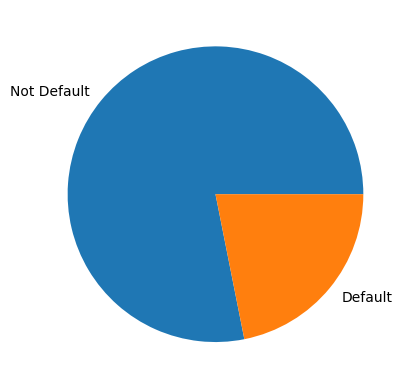

In [47]:
plt.pie(df.loan_status.value_counts().values, labels = ['Not Default', 'Default'])

In [48]:
# check missing values
df.isnull().sum().sort_values(ascending=False) / df.shape[0]

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_status                   0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64

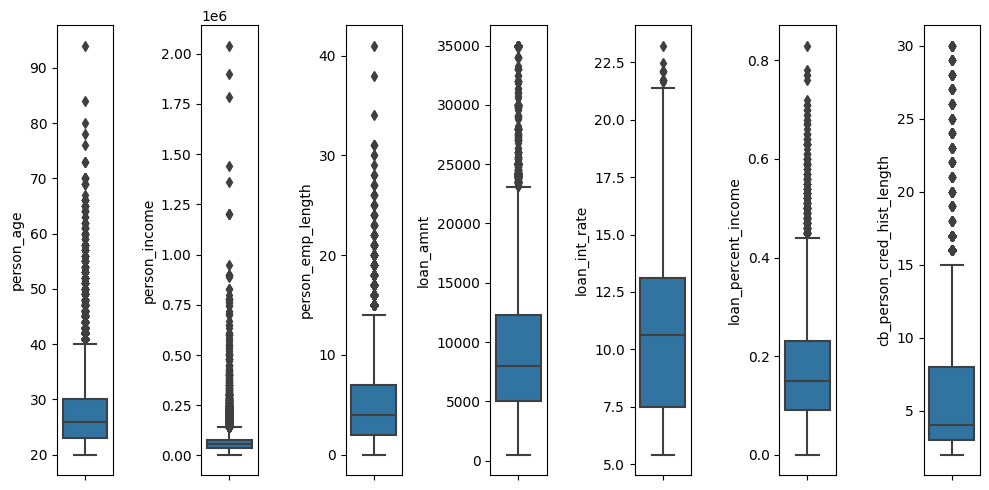

In [49]:
# check outliers

dfq = ['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
plt.figure(figsize=(10,5))
for i in range(0,len(dfq)):
    plt.subplot(1,len(dfq),i+1)
    sns.boxplot(y=df[dfq[i]])
    plt.tight_layout()

In [50]:
# Distribution of numeric columns

dfcount=['person_age','person_home_ownership','person_emp_length','loan_intent','loan_grade','loan_status','cb_person_default_on_file','cb_person_cred_hist_length']
dfhisto=['person_income','loan_amnt','loan_int_rate','loan_percent_income']

for i in range (0,len(dfcount)):
    plt.figure(figsize=(25,5))
    sns.countplot(df[dfcount[i]])
    plt.show()
for i in range (0,len(dfhisto)):
    plt.figure(figsize=(25,5))
    sns.histplot(df[dfhisto[i]],kde=True)
    plt.show()

KeyError: ignored

<Figure size 2500x500 with 0 Axes>

# Data Prepare

### Drop duplicated

In [11]:
df.duplicated().sum()

165

In [12]:
print(df.shape)
df.drop_duplicates(keep='first', inplace=True)
print('After dropping:', df.shape)

(32581, 12)
After dropping: (32416, 12)


### Fill missing value
- Loan interest rate: have outliers so this feature null values are filled by mode.
- Employment length: filled by employment length of customers with the same age

In [13]:
# fill missing interest rate
interest_rate_mode = df['loan_int_rate'].mode()[0]
df['loan_int_rate'] = df['loan_int_rate'].fillna(interest_rate_mode)

In [14]:
# fill missing employment length

age_list = df[df.person_emp_length.isnull() == True]['person_age'].unique()

for age in age_list:
    df.loc[((df['person_age']==age)&(df.person_emp_length.isnull() == True))\
           ,['person_emp_length']] = df[df['person_age']==age]['person_emp_length'].value_counts().idxmax()

In [42]:
df.person_emp_length.isnull().sum()

0

### Change datatype

In [43]:
df.person_emp_length = df.person_emp_length.astype('int64')

###  Drop outliers

In [16]:

# employment length > 100
df = df[df.person_emp_length < 100]
# Loai age > 100
df = df[df.person_age < 100]

# Encoding

In [ ]:
cat_cols

In [17]:

df2 = df.copy()
# label encode
df2.cb_person_default_on_file = LabelEncoder().fit_transform(df2['cb_person_default_on_file'])
# one hot encode
df2 = pd.get_dummies(df2, columns=['person_home_ownership', 'loan_intent'], drop_first=True)
# ordinal encode
df2.loan_grade = pd.Categorical(df2.loan_grade)
df2.loan_grade = df2.loan_grade.cat.codes

In [ ]:
df2.head()

# Feature Selection

### VIF

In [18]:
# VIF (Variance Inflation Factor) checking
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = df2.columns
vif_data['VIF'] = [variance_inflation_factor(df2.values, i) for i in range(len(df2.columns))]
pd.set_option('display.max_rows', None)

# column's vif
vif_data.sort_values(by= 'VIF', ascending = False)

,feature,VIF
0,person_age,42.238949
5,loan_int_rate,31.300456
7,loan_percent_income,9.636720
9,cb_person_cred_hist_length,8.775037
4,loan_amnt,8.646961
3,loan_grade,7.691687
1,person_income,4.539903
2,person_emp_length,2.642818
12,person_home_ownership_RENT,2.587063
13,loan_intent_EDUCATION,2.149922


In [19]:
# Move target variable to the last
df2 = df2[['person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_status']]

### Pearson Correlation

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_status
person_age,1.000000,0.140487,0.154399,0.012912,0.051646,0.006999,-0.041468,0.006584,0.878240,-0.008220,-0.000680,-0.031515,-0.092549,0.076166,0.021289,0.034235,-0.013578,-0.021774
person_income,0.140487,1.000000,0.146361,-0.003481,0.316732,-0.002428,-0.294766,-0.002520,0.122654,0.011635,-0.044837,-0.209536,-0.016898,0.051652,-0.040265,0.007301,0.004199,-0.169262
person_emp_length,0.154399,0.146361,1.000000,-0.050060,0.105031,-0.052923,-0.053691,-0.031094,0.134918,-0.015712,0.029839,-0.232430,-0.038373,0.032406,-0.002741,0.007871,0.010300,-0.081980
loan_grade,0.012912,-0.003481,-0.050060,1.000000,0.145955,0.845252,0.122773,0.536726,0.014070,0.018347,-0.017048,0.120177,-0.008226,0.029687,0.001015,-0.006739,-0.010778,0.373398
loan_amnt,0.051646,0.316732,0.105031,0.145955,1.000000,0.131467,0.572632,0.039135,0.042139,0.013010,-0.026027,-0.116556,-0.008923,0.043003,-0.024304,-0.001186,-0.000953,0.105601
loan_int_rate,0.006999,-0.002428,-0.052923,0.845252,0.131467,1.000000,0.107454,0.453805,0.010313,0.013961,-0.010328,0.125949,-0.006913,0.022011,0.002934,0.000013,-0.009811,0.306383
loan_percent_income,-0.041468,-0.294766,-0.053691,0.122773,0.572632,0.107454,1.000000,0.035911,-0.031214,0.011203,0.050843,0.116645,-0.000363,-0.015682,0.013497,-0.003922,0.000784,0.379580
cb_person_default_on_file,0.006584,-0.002520,-0.031094,0.536726,0.039135,0.453805,0.035911,1.000000,0.004239,0.014538,-0.003617,0.060916,-0.006890,0.015116,-0.002712,-0.003349,-0.002955,0.179245
cb_person_cred_hist_length,0.878240,0.122654,0.134918,0.014070,0.042139,0.010313,-0.031214,0.004239,1.000000,-0.006657,0.004957,-0.026182,-0.078386,0.058666,0.016123,0.035453,-0.008556,-0.016441
person_home_ownership_OTHER,-0.008220,0.011635,-0.015712,0.018347,0.013010,0.013961,0.011203,0.014538,-0.006657,1.000000,-0.016787,-0.057886,-0.005375,0.000422,-0.003832,0.000035,0.009134,0.012835


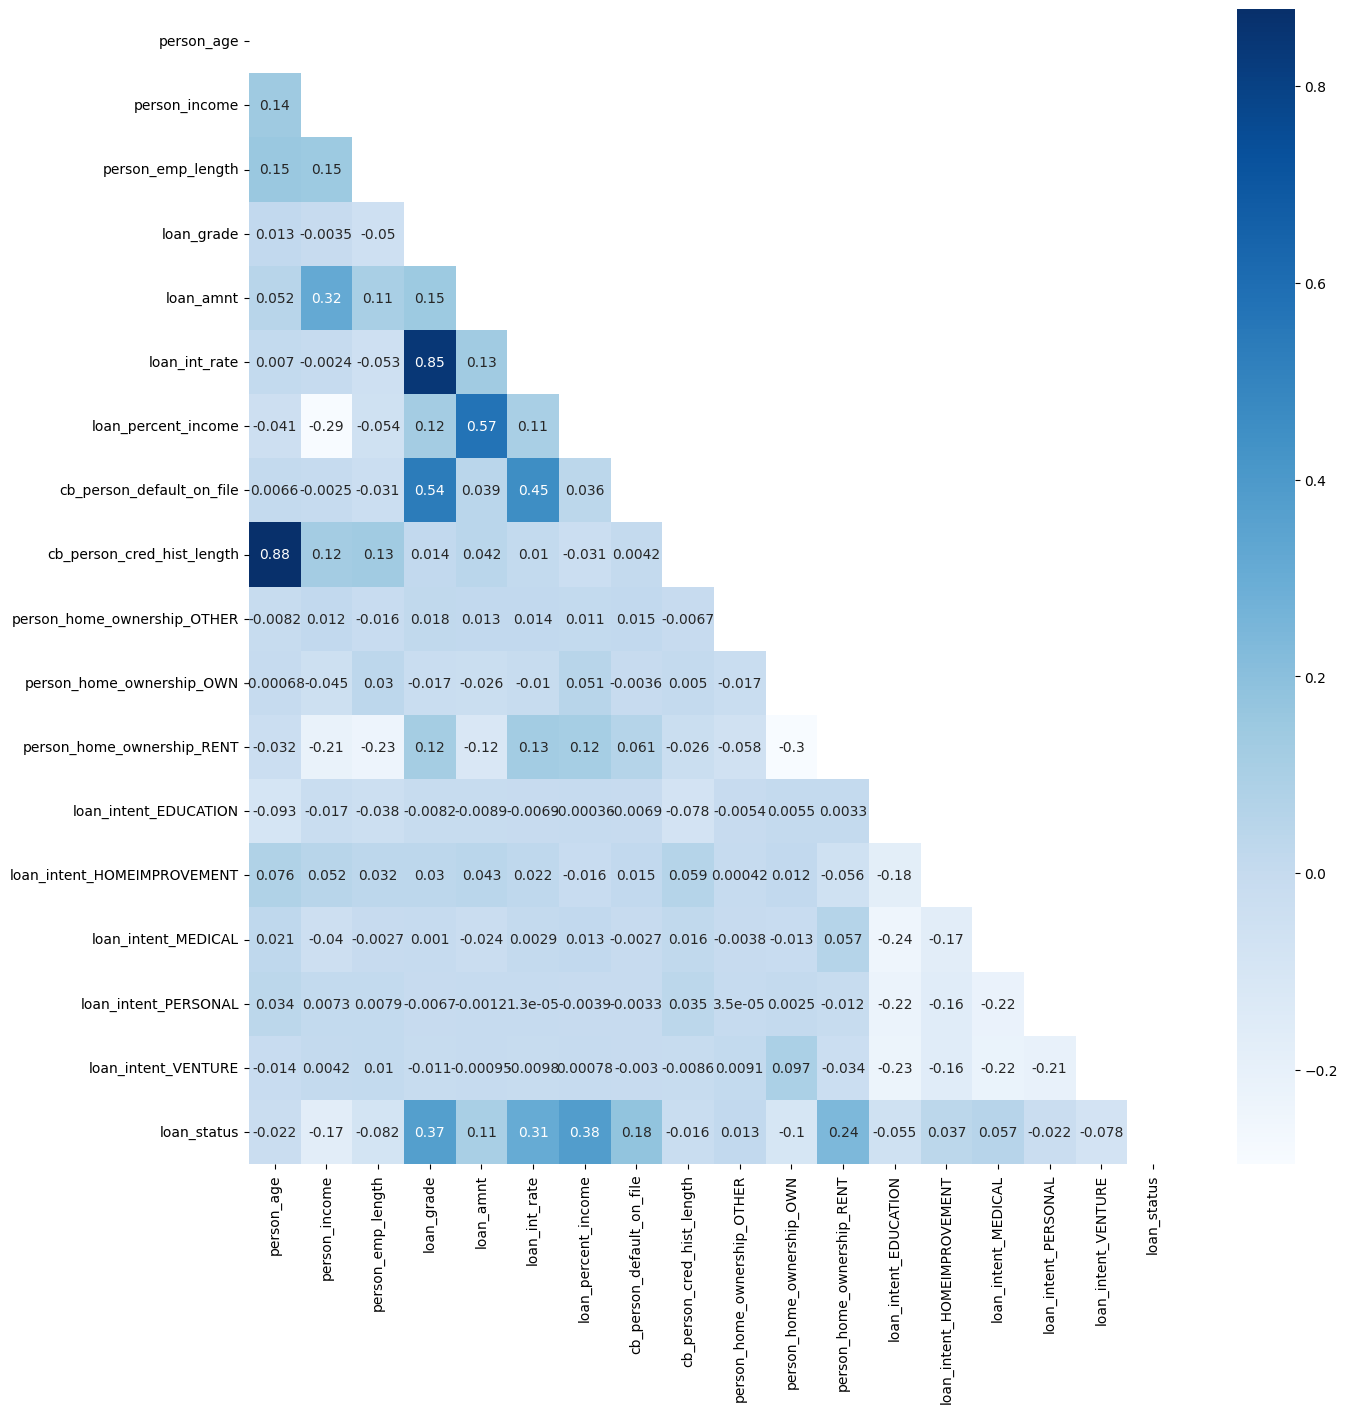

person_income                  0.169262
person_emp_length              0.081980
loan_grade                     0.373398
loan_amnt                      0.105601
loan_int_rate                  0.306383
loan_percent_income            0.379580
cb_person_default_on_file      0.179245
cb_person_cred_hist_length     0.016441
person_home_ownership_OTHER    0.012835
person_home_ownership_OWN      0.101937
person_home_ownership_RENT     0.238118
loan_intent_EDUCATION          0.055412
loan_intent_HOMEIMPROVEMENT    0.036603
loan_intent_MEDICAL            0.056654
loan_intent_PERSONAL           0.021681
loan_intent_VENTURE            0.078151
Name: loan_status, dtype: float64


The average value of the correlation with the target is:  0.1383299805929715


Correlation higher than correlation mean
person_income                 0.169262
loan_grade                    0.373398
loan_int_rate                 0.306383
loan_percent_income           0.379580
cb_person_default_on_file     0.179245
person_ho

In [20]:
# Feature Selection (Pearson Correlation)
plt.figure(figsize = (15,15))
correl = df2.corr()
display(correl)
mask = np.triu(np.ones_like(correl, dtype=bool))
sns.heatmap(correl, annot = True, cmap = plt.cm.Blues, mask=mask)
plt.show()

print(abs(correl['loan_status'][1:-1]))
correl['loan_status'] = correl['loan_status'][1:-1]
corr_mean = abs(correl['loan_status'][1:-1]).mean()
print('\n')
print('The average value of the correlation with the target is: ', corr_mean)
print('\n')
print('Correlation higher than correlation mean')
high_corr = abs(correl['loan_status'][1:-1])[abs(correl['loan_status']) > corr_mean]
print(high_corr)

### Drop Columns

In [21]:
# To drop: loan_int_rate, person_age
df2.drop(columns=['loan_int_rate', 'person_age'], inplace=True)

### Scale values

In [22]:
# scale
min_max_cols = ['person_income', 'loan_amnt', 'cb_person_cred_hist_length']
for col in min_max_cols:
    df2[col] = MinMaxScaler().fit_transform(df2[[col]])

In [ ]:
df2.head()

In [23]:
# Chia train, test
X = df2.drop(columns='loan_status')
y = df2.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print("X =", X_train.shape, X_test.shape)
print("y =", y_train.shape, y_test.shape)

X = (22686, 15) (9723, 15)
y = (22686,) (9723,)


In [24]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [25]:
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: loan_status, dtype: float64

In [26]:
y_train = pd.Series(y_train)
X_train = pd.DataFrame(X_train)

# Model Selection: K-fold Cross Validation

Streaming output truncated to the last 5000 lines.
87:	learn: 0.2636812	total: 572ms	remaining: 5.92s
88:	learn: 0.2623118	total: 578ms	remaining: 5.92s
89:	learn: 0.2619877	total: 585ms	remaining: 5.92s
90:	learn: 0.2614762	total: 591ms	remaining: 5.9s
91:	learn: 0.2611639	total: 597ms	remaining: 5.89s
92:	learn: 0.2607885	total: 603ms	remaining: 5.88s
93:	learn: 0.2593900	total: 609ms	remaining: 5.87s
94:	learn: 0.2589430	total: 616ms	remaining: 5.87s
95:	learn: 0.2583773	total: 622ms	remaining: 5.86s
96:	learn: 0.2576222	total: 628ms	remaining: 5.85s
97:	learn: 0.2566103	total: 634ms	remaining: 5.84s
98:	learn: 0.2561587	total: 641ms	remaining: 5.83s
99:	learn: 0.2558385	total: 647ms	remaining: 5.82s
100:	learn: 0.2548279	total: 653ms	remaining: 5.81s
101:	learn: 0.2534809	total: 659ms	remaining: 5.8s
102:	learn: 0.2528013	total: 673ms	remaining: 5.86s
103:	learn: 0.2523628	total: 679ms	remaining: 5.85s
104:	learn: 0.2505535	total: 686ms	remaining: 5.84s
105:	learn: 0.2498232	total:

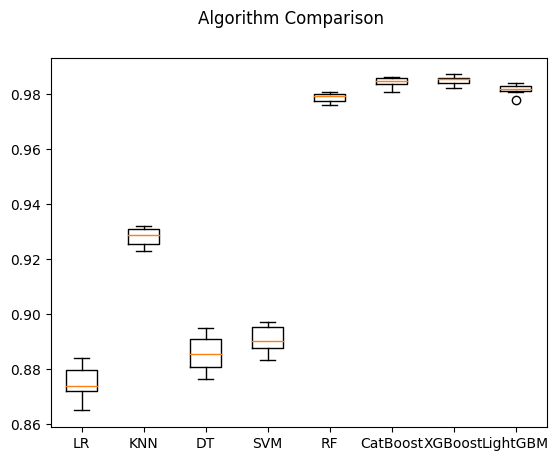

In [27]:
num_fold = 10
seed = 42
models = [('LR',LogisticRegression()),('KNN',KNeighborsClassifier()),('DT',DecisionTreeClassifier()),('SVM',SVC()),('RF',RandomForestClassifier()), \
          ('CatBoost', CatBoostClassifier()), ('XGBoost', XGBClassifier()), \
            ('LightGBM', LGBMClassifier())]
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    ### initialize KFOLD here. Choose n_splits = 10, random_state = 99. suffle = True
    kfold = KFold(n_splits=num_fold, random_state=seed, shuffle=True)

    #### Calculate auc_score for each model, assign the result to cv_result
    cv_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_result)
    names.append(name)
    #### append cv_result to results, append name to names
    msg = "%s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Hyperparameter Tuning: Bayesian optimization with Optuna

In [ ]:
import optuna

In [38]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    return accuracy

In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-09-28 16:46:00,716] A new study created in memory with name: no-name-2c597fb4-6957-41aa-922a-4cc12e88a910
[I 2023-09-28 16:46:04,528] Trial 0 finished with value: 0.9070245808906716 and parameters: {'learning_rate': 0.07083682929251152, 'depth': 2, 'subsample': 0.9183872849642707, 'colsample_bylevel': 0.18027985040438133, 'min_data_in_leaf': 29}. Best is trial 0 with value: 0.9070245808906716.
[I 2023-09-28 16:46:10,157] Trial 1 finished with value: 0.8644451301038774 and parameters: {'learning_rate': 0.0019967924620726395, 'depth': 6, 'subsample': 0.12812260929068775, 'colsample_bylevel': 0.13064346601142957, 'min_data_in_leaf': 33}. Best is trial 0 with value: 0.9070245808906716.
[I 2023-09-28 16:46:14,533] Trial 2 finished with value: 0.9315026226473311 and parameters: {'learning_rate': 0.04997946492617439, 'depth': 4, 'subsample': 0.2767419311463872, 'colsample_bylevel': 0.4011654646737736, 'min_data_in_leaf': 60}. Best is trial 2 with value: 0.9315026226473311.
[I 2023-09-

In [40]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

Best hyperparameters: {'learning_rate': 0.023132355884768387, 'depth': 7, 'subsample': 0.29944926393585775, 'colsample_bylevel': 0.9983782878494984, 'min_data_in_leaf': 65}
Best accuracy: 0.9342795433508176


In [55]:
# evaluation function
def evaluation(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("="*50)

    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print("Accuracy of TRAIN data:", 100*accuracy_score(y_train, y_train_pred))
    print("F1_Score of TRAIN data:", 100*f1_score(y_train, y_train_pred, average="macro"))
    print("="*50)

    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    print("Accuracy of TEST data:", 100*accuracy_score(y_test, y_test_pred))
    print("F1_Score of TEST data:", 100*f1_score(y_test, y_test_pred, average="macro"))
    print("="*50)

    # calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred, average=None)
    print("ROC AUC score: ", roc_auc)


In [52]:
model = CatBoostClassifier(learning_rate=0.023132355884768387, depth=7, subsample=0.29944926393585775, \
                           colsample_bylevel=0.9983782878494984, min_data_in_leaf=65,random_seed=42)

0:	learn: 0.6755975	total: 19.2ms	remaining: 19.2s
1:	learn: 0.6521236	total: 38.8ms	remaining: 19.4s
2:	learn: 0.6380767	total: 53.4ms	remaining: 17.8s
3:	learn: 0.6195861	total: 71.1ms	remaining: 17.7s
4:	learn: 0.6009364	total: 87.8ms	remaining: 17.5s
5:	learn: 0.5857041	total: 104ms	remaining: 17.3s
6:	learn: 0.5756540	total: 121ms	remaining: 17.1s
7:	learn: 0.5625664	total: 138ms	remaining: 17.1s
8:	learn: 0.5516006	total: 155ms	remaining: 17.1s
9:	learn: 0.5408022	total: 174ms	remaining: 17.2s
10:	learn: 0.5286352	total: 190ms	remaining: 17.1s
11:	learn: 0.5168458	total: 206ms	remaining: 17s
12:	learn: 0.5084311	total: 227ms	remaining: 17.2s
13:	learn: 0.4977654	total: 241ms	remaining: 17s
14:	learn: 0.4923384	total: 258ms	remaining: 16.9s
15:	learn: 0.4856908	total: 274ms	remaining: 16.8s
16:	learn: 0.4798204	total: 290ms	remaining: 16.8s
17:	learn: 0.4731768	total: 311ms	remaining: 16.9s
18:	learn: 0.4684441	total: 331ms	remaining: 17.1s
19:	learn: 0.4636395	total: 349ms	remain

### We might get the best predictor here but let's look at other models' metric results

In [56]:
xgb_model = XGBClassifier(random_seed=42)
evaluation(xgb_model)

[17:07:23] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[[17642    74]
 [ 1099 16617]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17716
           1       1.00      0.94      0.97     17716

    accuracy                           0.97     35432
   macro avg       0.97      0.97      0.97     35432
weighted avg       0.97      0.97      0.97     35432

Accuracy of TRAIN data: 96.68943328065026
F1_Score of TRAIN data: 96.68666045642347
[[7491  114]
 [ 539 1579]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7605
           1       0.93      0.75      0.83      2118

    accuracy                           0.93      9723
   macro avg       0.93      0.87      0.89      9723
weighted avg       0.93      0.93      0.93      9723

Accuracy of TEST data: 93.28396585416023
F1_Score of TEST data: 89.34443131940036
RMSE:  0.2591531235744567
ROC AUC

In [57]:
from xgboost import plot_importance

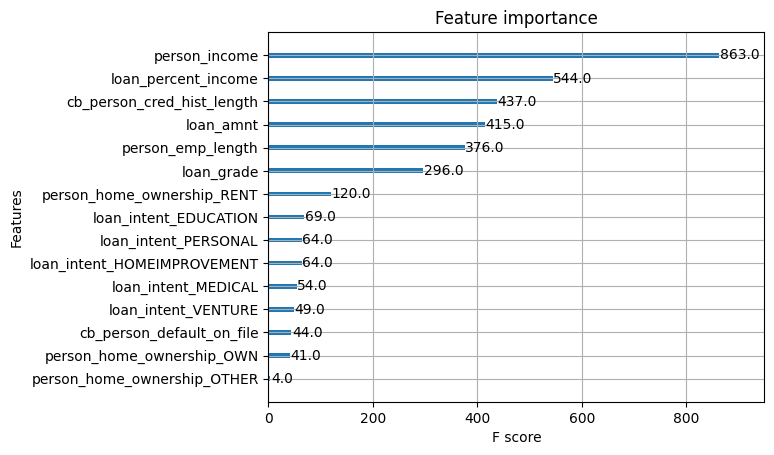

<Figure size 640x480 with 0 Axes>

In [58]:
plot_importance(xgb_model)
plt.show()
plt.savefig("Feature importance.png")

In [59]:
lgbm_model = LGBMClassifier(random_state=42)
evaluation(lgbm_model)

[LightGBM] [Info] Number of positive: 17716, number of negative: 17716
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 35432, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[17582   134]
 [ 1579 16137]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17716
           1       0.99      0.91      0.95     17716

    accuracy                           0.95     35432
   macro avg       0.95      0.95      0.95     35432
weighted avg       0.95      0.95      0.95     35432

Accuracy of TRAIN data: 95.16538722059155
F1_Score of TRAIN data: 95.15733289883303
[[7506   99]
 [ 567 1551]]
              precision  

In [60]:
knn = KNeighborsClassifier(n_neighbors = 2)
evaluation(knn)

[[17716     0]
 [ 1353 16363]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17716
           1       1.00      0.92      0.96     17716

    accuracy                           0.96     35432
   macro avg       0.96      0.96      0.96     35432
weighted avg       0.96      0.96      0.96     35432

Accuracy of TRAIN data: 96.18141792729736
F1_Score of TRAIN data: 96.17584170447446
[[6955  650]
 [ 876 1242]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7605
           1       0.66      0.59      0.62      2118

    accuracy                           0.84      9723
   macro avg       0.77      0.75      0.76      9723
weighted avg       0.84      0.84      0.84      9723

Accuracy of TEST data: 84.30525557955364
F1_Score of TEST data: 76.02957816652977
RMSE:  0.3961659301409747
ROC AUC score:  0.7504660904094331
